In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import scipy.special as special
from scipy.integrate import quad
from scipy.integrate import nquad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
#pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'    

In [269]:
#want to plot the integrand in Eq. 60 of the paper
#with filled in values of I(...), delta(yn), 

#constants in natural units
#m = 1.
#c = 1.
theta_e = 10.
#nu_c = 1
#B = 10.
#e = 1


#constants in Gaussian cgs units (values from harmony)
m = 9.1093826e-28
c = 2.99792458e10
e = 4.80320680e-10
B = 30.0
n_e = 1.




#variables to be set (frequency, observer angle, width of delta function, electron number density, 
# sum index n)


theta = np.pi/3.
epsilon = 0.01
n_e = 1
nu_c = e * B / (2. * np.pi * m * c)
nu = 100 * nu_c
nu_s = (2./9.) * nu_c * theta_e**2 * np.sin(theta)
n_e_nt = 1.
#p_PL = 2.2
p_PL = 4.5
gamma_50_min = 1.
gamma_50_max = 1000.
#gamma_50_max = 100.
C = 1.
n_dn = (nu / nu_c) * abs(np.sin(theta))
Index_cutoff = 0.001
kappa = 3.5
gamma_cutoff = 1000.

In [461]:
def thermal_dist(gamma):
    frefactor = n_e / (4. * np.pi * theta_e)
    body = gamma * np.sqrt(gamma**2 - 1.) / (special.kn(2., 1./theta_e))
    tail = np.exp(- gamma / theta_e)
    f = frefactor * body * tail
    return f

norm_thermal = quad(thermal_dist, 1, np.inf, epsabs = 0, epsrel = 1e-8)[0] 
#print 1./norm_thermal

A_prim = (1. / norm_thermal) * (n_e / (4. * np.pi * theta_e)) * ( 1. / (special.kn(2., 1./theta_e)))
#A_prim = (4. * np.pi) * (n_e / (4. * np.pi * theta_e)) * ( 1. / (special.kn(2., 1./theta_e)))



def kappa_dist(gamma):
    frefactor = m**3 * c**3 * gamma * np.sqrt(gamma**2 - 1.)
    body = (1 + (gamma - 1.)/(kappa * theta_e))**(- kappa - 1.)
    tail = np.exp(- gamma / gamma_cutoff)
    f = frefactor * body
    return f

norm_kappa = quad(kappa_dist, 1, np.inf, epsabs = 0, epsrel = 1e-8)[0]
A = (1. / norm_kappa) * m**3 * c**3

C_low = (2**(4./3.) * np.pi / 3.) * ((n_e * e**2 * nu_s) / (c * theta_e**2)) * (1. / nu_s)**(1. / 3.)

def M_J(x):
    f = C_low * x**(1./3.)
    return f

def kappa_low_freq(x):
    f = C_low * (A_prim / A) * x**(1. / 3.)
    return f


C_high = n_e * (np.sqrt(2.) * np.pi * e**2 * nu_s / (6. * theta_e**2 * c)) * (1. / nu_s)

def kappa_high_freq(x):
    f = C_high * (A_prim / A) * x * np.exp(- (x / nu_s)**(1./3.))
#    f = C_high * (A_prim / A) * x * np.exp(- x)


    return f

def power_dist(gamma):
    prefactor = n_e_nt * (p_PL - 1.) / (4. * np.pi * (gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL)))
    body = gamma**(- p_PL)
    tail = np.exp(- gamma / gamma_cutoff)
    f = prefactor * body * tail
    return f

norm_power = quad(power_dist, 1, np.inf, epsabs = 0, epsrel = 1e-8)[0]

A_power = (1. / norm_power)*n_e_nt*(p_PL - 1.) / (4. * np.pi * (gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL)))

def C_middle():
    first_part       = n_e_nt * (e**2 * nu_c /c)
    second_part_nume = 3.**(p_PL/2.) * (p_PL - 1.) * np.sin(theta)
    second_part_demo = 2. * (p_PL + 1.) * (gamma_50_min**(1. - p_PL) - gamma_50_max**(1. - p_PL))
    second_part      = second_part_nume/second_part_demo
    third_part       = special.gamma((3. * p_PL - 1.)/ 12.) * special.gamma((3. * p_PL + 19.)/12.)
    forth_part       = (1./(nu_c * np.sin(theta)))**(- (p_PL - 1.)/2.)
    ans              = first_part * second_part * third_part * forth_part
    return ans

def kappa_middle_freg(x):
    f = C_middle() * (A_power / A) * x**(- (p_PL - 1.)/2.)
    return f

def mix_haha(x):
#1    f = ((kappa_low_freq(x))**(1./2.) + (kappa_middle_freg(x))**(9./24.) + (kappa_high_freq(x))**(1./4.))**4
    f_1 = (1e4*(kappa_low_freq(x))**(1./2.) + (kappa_middle_freg(x))**(9./24.) + (kappa_high_freq(x))**(1./4.))**4
    f = ((kappa_low_freq(x))**(1./2.) + (kappa_middle_freg(x))**(9./24.) + (kappa_high_freq(x))**(1./4.))**4
#    f = f_1 * np.exp(- ((x / 1e6 * nu_c) - 1 )**(1./10.))
    return f


#print C_low, C_high, A_prim / A, nu_s

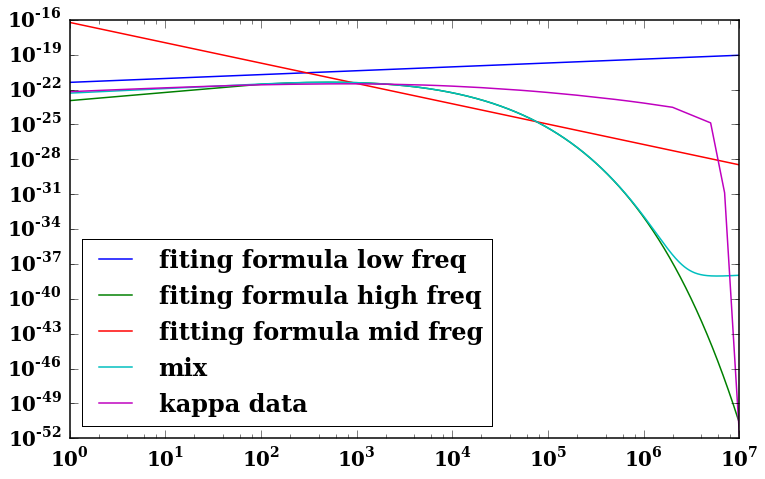

In [463]:
x_here = np.arange(1, 1e7, 100)
#pl.loglog(x_here, M_J(x_here * nu_c))
pl.loglog(x_here, kappa_low_freq(x_here * nu_c), label = 'fiting formula low freq')
pl.loglog(x_here, kappa_high_freq(x_here * nu_c), label = 'fiting formula high freq')
pl.loglog(x_here, kappa_middle_freg(x_here * nu_c), label = 'fitting formula mid freg')
pl.loglog(x_here, mix_haha(x_here * nu_c), label = 'mix')


#pl.loglog(x_here, )

data1 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_3_5_with_cutoff1000_with_norm.txt')
pl.loglog(data1[:, 0], data1[:, 1], label = 'kappa data')
#pl.xlim([0, 1e6])
pl.legend(loc = 'lower left')
pl.show()

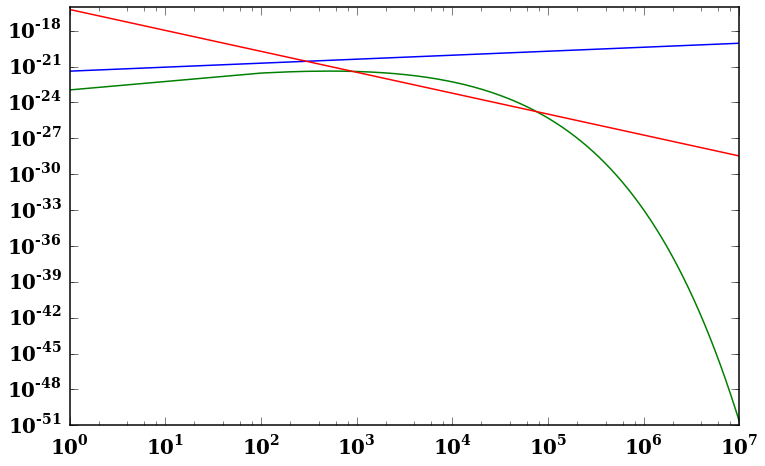

In [460]:
x_here = np.arange(1, 1e7, 100)
#pl.loglog(x_here, M_J(x_here * nu_c))
pl.loglog(x_here, kappa_low_freq(x_here * nu_c), label = 'fiting formula low freq')
pl.loglog(x_here, kappa_high_freq(x_here * nu_c), label = 'fiting formula high freq')
pl.loglog(x_here, kappa_middle_freg(x_here * nu_c), label = 'fitting formula mid freg')

In [80]:
np.exp(1)

2.7182818284590451

In [114]:
(1*
2
*3)

6